In [12]:
import os
import numpy as np
import matplotlib as mpl  
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.cm import ScalarMappable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.lines import Line2D
import seaborn as sns
from math import e, sin, pi, ceil
from matplotlib import colors
import colorsys
from scipy.optimize import least_squares
from numpy import log
import pandas as pd
from tqdm import tqdm
from utils import *

In [13]:
mpl.rc('font',family='Times New Roman', size=30)
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

In [14]:
# Make color map
viridis = mpl.colormaps['viridis']
newcolors = viridis(np.linspace(0, 1, 100))[0:80]
cmap = ListedColormap(newcolors)

In [15]:
def constant_r(t, T, r=0.037):
    return r

def recursive_price(T, time=1, r=0.037, g=0.007, D=1, r_func=constant_r):
    if T==0:
        return 0
    else:
#         print(f'T: {T}, r: {r_func(T,r=r)}')
        dividend = D*(1+g)
        next_price = recursive_price(T-1, r=r, g=g, time=time+1, D=dividend, r_func=r_func)
        return (dividend + next_price)/(1+r_func(time, T=T,r=r))

In [16]:
def gordon_growth(T, r=0.037, g=0.007, D=1):
    p1tT = 0
    for i in range(1,int(T)+1):
        p1tT += D * ((1+g)/(1+r))**i
    return p1tT

def d_log_price(T, r=0.037, g=0.007, k=90):
	return log(gordon_growth(T+k, r=r, g=g)) - log(gordon_growth(T, r=r, g=g))

def nlls(theta, T, y, g=0.007):
    est_y =  np.array(list(map(lambda t: d_log_price(t, r=theta+g, g=g, k=90), T)))
    return y - est_y

def objective_function(params, P, T, g, k, func):
    r = params[0]
    estimated_P = func(T=int(T), r=r, g=g, k=k)
    return P - estimated_P

def estimate_rK(P, T, g=0.007, k=90, func=d_log_price, initial_guess = [0.05]):

    result = least_squares(objective_function, initial_guess, args=(P, T, g, k, func))

    if result.success:
        return result.x[0] - g
    else:
        print("Could not converge!")
        return None


In [17]:
def metafunc(alpha=1, beta=None, gamma=None, delta=None):
    def func(x, r=None, g=0.007, T=None):
        y = 0.037 + alpha*np.e**(-0.1*(x+40))
        if y>0:
            return y
        else:
            return 0
    return func

In [18]:
# Set multiple possible forward yield functions
def f1(t, T=None, r=0.037, g=0.007):
    return r

def f2(t, T=None, r=0.037, g=0.007):
    rlim = r
    if t<=40:
        return (rlim-0.02) + 0.02/(1+e**(-0.2*(t-5)))
    else:
        return rlim
    
def f3(t, T=None, r=0.037, g=0.007):
    rlim = r
    if t<=40:
        return (rlim+0.02) - 0.02/(1+e**(-0.2*(t-5)))
    else:
        return rlim

def f4(t, T=None, r=0.037, g=0.007):
    rlim = r
    if t<=37.71:
        return rlim-0.01*sin(0.3*(t-6))
    else:
        return rlim
    
def f5(t, T=None, r=0.037, g=0.007):
    if t<=40:
        return t * (r-0.01)/40 + 0.01
    else:
        return r
    
def f6(t, T=None, r=0.037, g=0.007):
    if t<=40:
        return g
    else:
        return r
    
def f_nelson_siegel(t, T=None, r=0.036, beta1=0.05, beta2=-0.1, tau=3, adjust=0.0070, g=0.007):
    
    t_ns = (t+2)/tau
    
    if t<=40:
        return r + adjust + beta1*(e**(-t_ns)) + beta2*((1-e**(-t_ns))/t_ns - e**(-t_ns))
    else:
        return r

# Figure 2: A Parameterization of the Housing Yield Curve

In [20]:
# Create f curve that passes through the average bond yields (2010-2021) -- weighted by the number of observations in each year
s0Y = 0.68/100
r10Y = 1.72/100
f10Y20Y = 2.53/100

def f_form(alpha, beta, gamma, delta, epsilon, x):
    # Flexible functional form
    return alpha - beta*epsilon**(-gamma*(x+delta))

def func(theta, y):
    
    
    alpha = theta[0]
    beta = theta[1]
    gamma = theta[2]
    delta = theta[3]
    epsilon = theta[4]
    
    df = pd.DataFrame({'duration':list(range(0,41))})
    df['f'] = 1+df.apply(lambda row: f_form(alpha, beta, gamma, delta, epsilon, row.duration), axis=1)
    df['cum_forwards'] = df.f.cumprod()
    df['yield_curve'] = (df.cum_forwards**(1/(df.duration)))
    
    est_s0Y = df.loc[df.duration==0, 'f'].values[0]-1
    est_r10Y = df.loc[df.duration==10, 'yield_curve'].values[0]-1
    est_r30Y = df.loc[df.duration==30, 'yield_curve'].values[0]-1
    est_f10Y20Y = (((1+est_r30Y)**30)/((1+est_r10Y)**10))**(1/20) - 1

    est_y = np.array([est_s0Y, est_r10Y, est_f10Y20Y])
    return y - est_y

# Solve for parameters
x0 =  np.array([0.03,0.04,0.5,-10,1.1])
y = np.array([s0Y, r10Y, f10Y20Y])
params = least_squares(func, x0, args=(y,)).x

# Turn all of this into a function
def f_example(t, T=None, r=None, g=0.007):
    return 0.002507 + f_form(params[0], params[1], params[2], params[3], params[4], t) + g


/var/folders/mj/79syxgbn0fv1ppcf4xrt_s740000gn/T/ipykernel_24963/3245626507.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return alpha - beta*epsilon**(-gamma*(x+delta))
/var/folders/mj/79syxgbn0fv1ppcf4xrt_s740000gn/T/ipykernel_24963/3245626507.py:8: RuntimeWarning: invalid value encountered in double_scalars
  return alpha - beta*epsilon**(-gamma*(x+delta))


In [21]:
df = pd.DataFrame({'duration':[T for T in range(1,120)]})
r=0.037
g=0.007
Tbar=40

# Create price for each function
functions = [f1, f2, f3, f4, f5, f6, f_nelson_siegel, f_example]
for i in tqdm(range(1,9)):
    func = functions[i-1]
    df[f'f{i}'] = df.apply(lambda row: func(row.duration, r=r, g=g), axis=1) - g
    
    # Get yield curve 
    df[f'forwards_p1{i}'] = 1 + df[f'f{i}']
    df[f'cum_forwards{i}'] = df[f'forwards_p1{i}'].cumprod()
    df[f'yield_curve{i}'] = (df[f'cum_forwards{i}']**(1/(df.duration)) - 1)
    
    df[f'price_Tbar{i}'] = recursive_price(Tbar, r=r, g=g, r_func=func)
    
    df[f'price{i}'] = df.apply(lambda row: recursive_price(row.duration+90, r=r, g=g, r_func=func), axis=1)
    df[f'L_price{i}'] = df.apply(lambda row: recursive_price(row.duration,  r=r, g=g, r_func=func), axis=1)
    df[f'd_log_price{i}'] = np.log(df[f'price{i}']) -np.log(df[f'L_price{i}'])
    
    # Estimate constant r for each T
    df[f'rK_T_{i}'] = df.apply(lambda row: estimate_rK(row[f'd_log_price{i}'], row.duration, g=g), axis=1)

100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.63it/s]


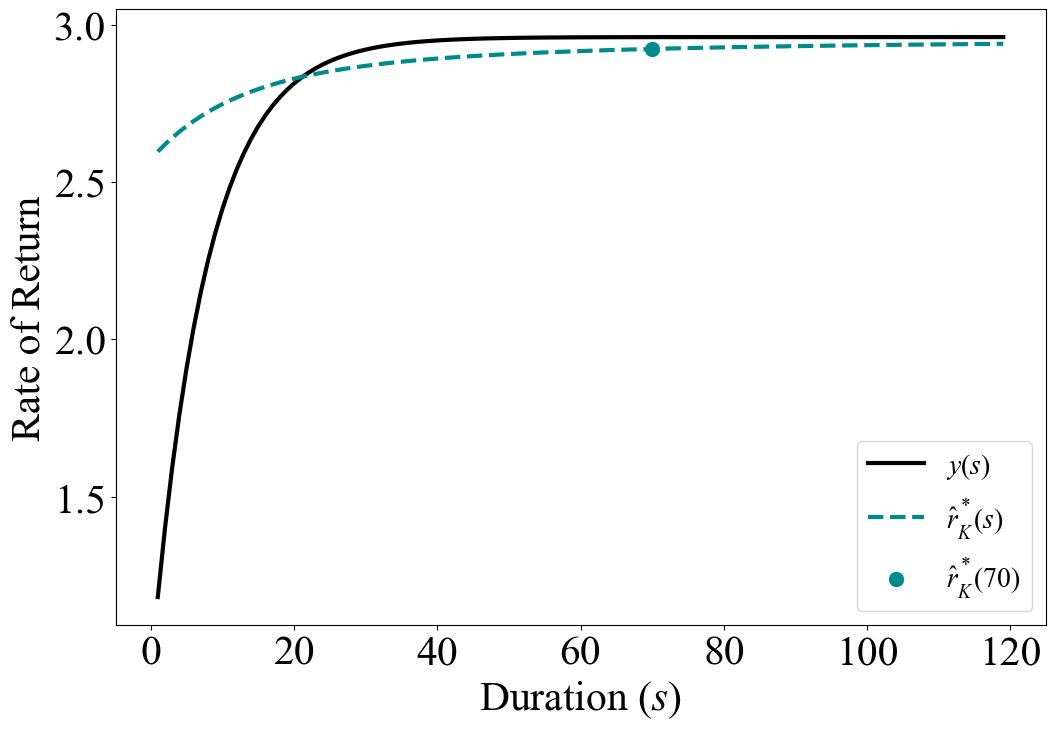

In [32]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df.duration, 100 * df.f8, label=r'$y(s)$', color='black', linewidth=3)
ax.plot(df.duration, 100 * df.rK_T_8, label=r'$\hat{r}_K^*(s)$', color='darkcyan', linestyle='dashed', linewidth=3)
ax.scatter(df[df.duration==70].duration, 100*df[df.duration==70].rK_T_8, color='darkcyan', s=100, label=r'$\hat{r}_K^*(70)$')
ax.legend(prop={'family': 'Times New Roman', 'size':20})
ax.set_ylabel('Rate of Return')
ax.set_xlabel(r'Duration ($s$)')

plt.savefig(os.path.join(figures_folder, 'yield_curve_example.png'))

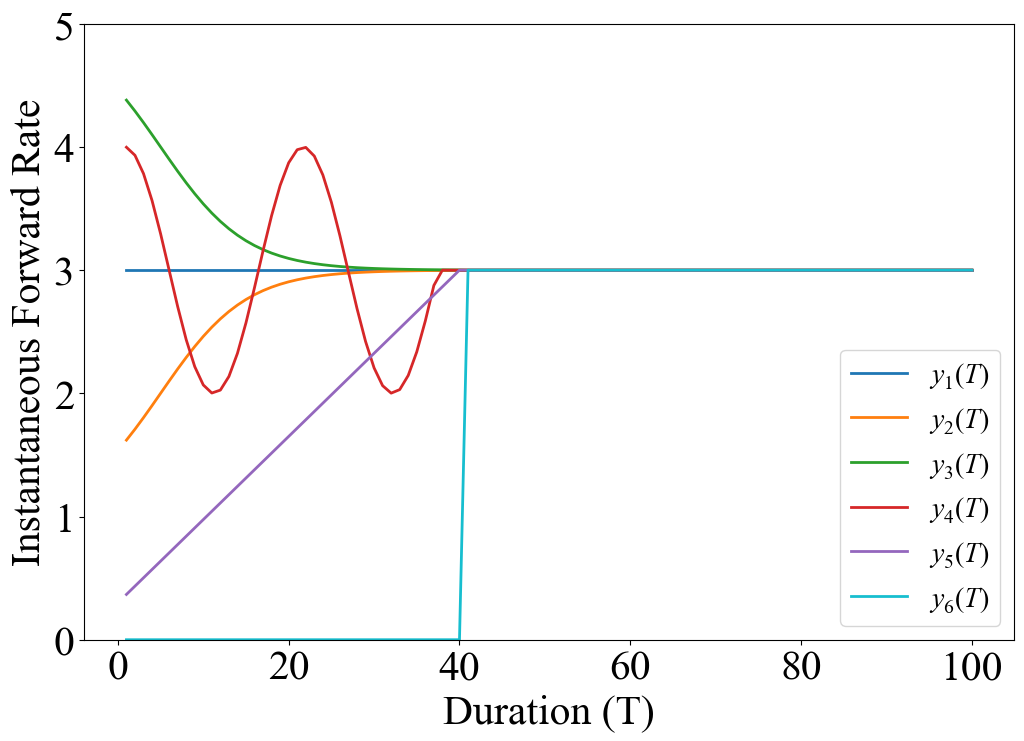

In [33]:
# Plot Forward Curves
fig, ax = plt.subplots(figsize=(12,8))
df = df[df.duration<=100]
ax.plot(df.duration, 100 * df.f1, label=r'$y_1(T)$', color='C0', linewidth=2)
ax.plot(df.duration, 100 * df.f2, label=r'$y_2(T)$', color='C1', linewidth=2)
ax.plot(df.duration, 100 * df.f3, label=r'$y_3(T)$', color='C2', linewidth=2)
ax.plot(df.duration, 100 * df.f4, label=r'$y_4(T)$', color='C3', linewidth=2)
ax.plot(df.duration, 100 * df.f5, label=r'$y_5(T)$', color='C4', linewidth=2)
ax.plot(df.duration, 100 * df.f6, label=r'$y_6(T)$', color='C9', linewidth=2)
ax.legend(prop={'family': 'Times New Roman', 'size':20})
ax.set_ylabel('Instantaneous Forward Rate')
ax.set_xlabel('Duration (T)')
ax.set_ylim([0, 5])
plt.savefig(os.path.join(figures_folder, 'forward_curves.png'))

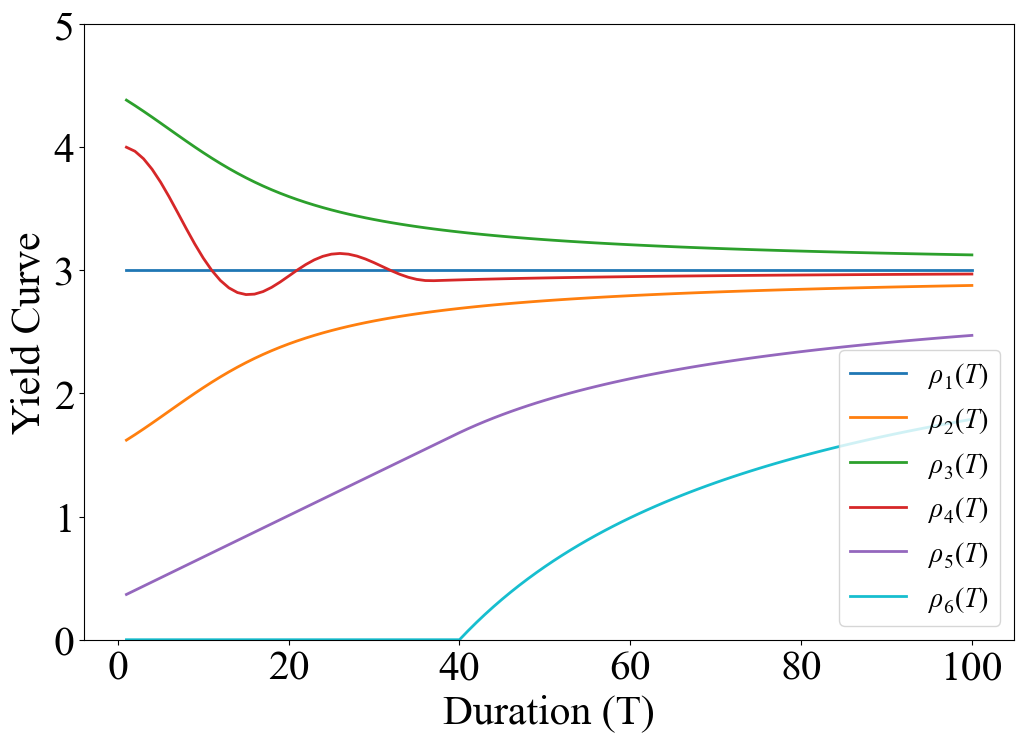

In [231]:
# Plot Yield Curves
fig, ax = plt.subplots(figsize=(12,8))
df = df[df.duration<=100]
ax.plot(df.duration, 100 * df.yield_curve1, label=r'$\rho_1(T)$', color='C0', linewidth=2)
ax.plot(df.duration, 100 * df.yield_curve2, label=r'$\rho_2(T)$', color='C1', linewidth=2)
ax.plot(df.duration, 100 * df.yield_curve3, label=r'$\rho_3(T)$', color='C2', linewidth=2)
ax.plot(df.duration, 100 * df.yield_curve4, label=r'$\rho_4(T)$', color='C3', linewidth=2)
ax.plot(df.duration, 100 * df.yield_curve5, label=r'$\rho_5(T)$', color='C4', linewidth=2)
ax.plot(df.duration, 100 * df.yield_curve6, label=r'$\rho_6(T)$', color='C9', linewidth=2)
ax.legend(prop={'family': 'Times New Roman', 'size':20})
ax.set_ylabel('Yield Curve')
ax.set_xlabel('Duration (T)')
ax.set_ylim([0, 5])
plt.savefig(os.path.join(figures_folder, 'yield_curves.png'))

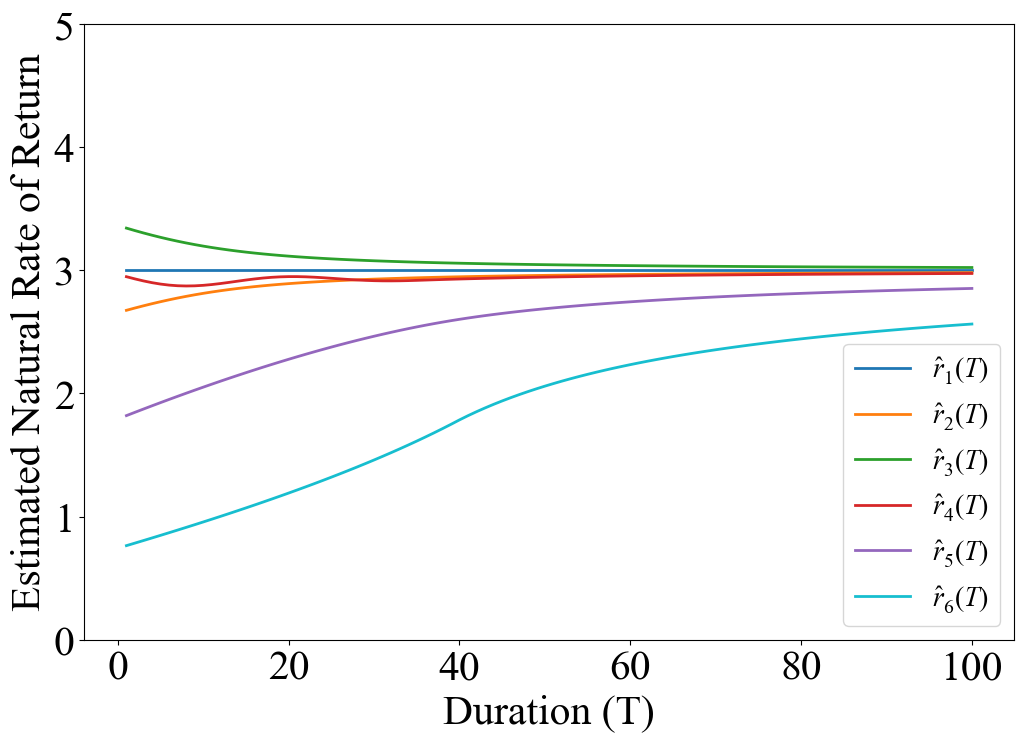

In [233]:
# Plot Estimated natural rate

fig, ax = plt.subplots(figsize=(12,8))
df = df[df.duration<=100]
ax.plot(df.duration, 100 * df.rK_T_1, label=r'$\hat{r}_1(T)$', color='C0', linewidth=2)
ax.plot(df.duration, 100 * df.rK_T_2, label=r'$\hat{r}_2(T)$', color='C1', linewidth=2)
ax.plot(df.duration, 100 * df.rK_T_3, label=r'$\hat{r}_3(T)$', color='C2', linewidth=2)
ax.plot(df.duration, 100 * df.rK_T_4, label=r'$\hat{r}_4(T)$', color='C3', linewidth=2)
ax.plot(df.duration, 100 * df.rK_T_5, label=r'$\hat{r}_5(T)$', color='C4', linewidth=2)
ax.plot(df.duration, 100 * df.rK_T_6, label=r'$\hat{r}_6(T)$', color='C9', linewidth=2)
ax.legend(prop={'family': 'Times New Roman', 'size':20})
ax.set_ylabel('Estimated Natural Rate of Return')
ax.set_xlabel('Duration (T)')
ax.set_ylim([0, 5])

plt.savefig(os.path.join(figures_folder, 'natural_rates.png'))

## Effect of extending to 160 from various durations

100%|█████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.22it/s]


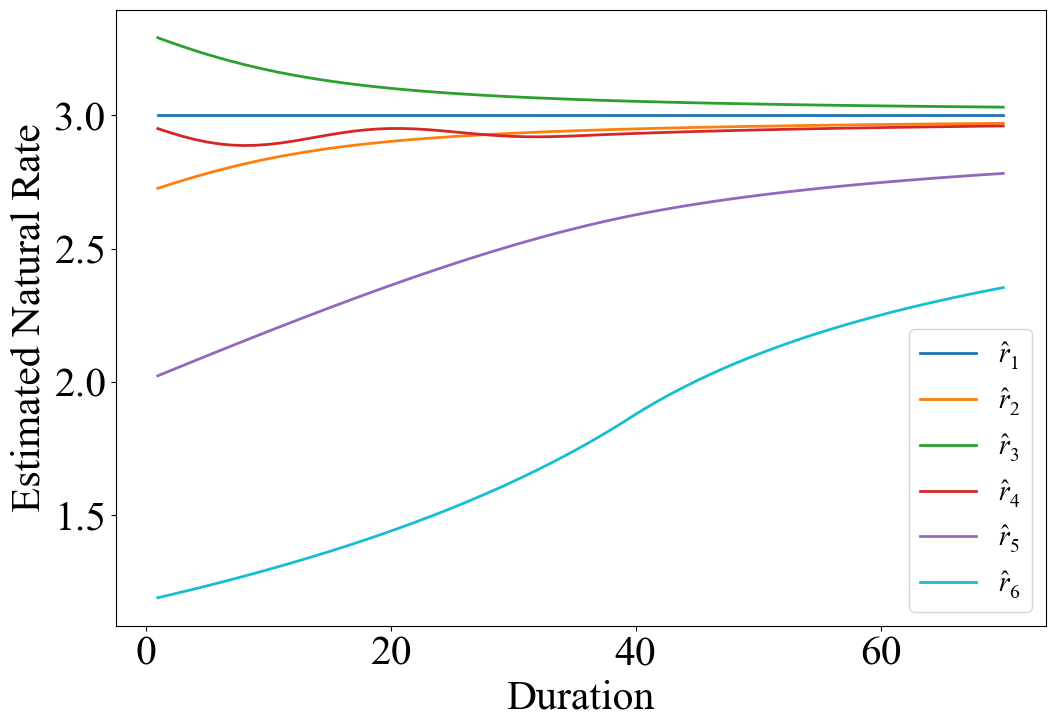

In [235]:
df = pd.DataFrame({'duration':list(range(1,71))})
df['k'] = 160 - df.duration

functions = [f1, f2, f3, f4, f5, f6]
for i in tqdm(range(1,7)):
    func = functions[i-1]
    df[f'price{i}'] =  df.apply(lambda row: recursive_price(160, r=r, g=g, r_func=func), axis=1)
    df[f'L_price{i}'] = df.apply(lambda row: recursive_price(row.duration, r_func=func, r=r, g=g), axis=1)
    df[f'd_log_price{i}'] = np.log(df[f'price{i}']) -np.log(df[f'L_price{i}'])
    df[f'rhat{i}'] = df.apply(lambda row: get_implied_r(row[f'd_log_price{i}'], row.duration, g=g, k=160-row.duration), axis=1)

# Plot:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df.duration, 100 * df.rhat1, color='C0', label=r'$\hat{r}_1$', linewidth=2)
ax.plot(df.duration, 100 * df.rhat2, color='C1', label=r'$\hat{r}_2$', linewidth=2)
ax.plot(df.duration, 100 * df.rhat3, color='C2', label=r'$\hat{r}_3$', linewidth=2)
ax.plot(df.duration, 100 * df.rhat4, color='C3', label=r'$\hat{r}_4$', linewidth=2)
ax.plot(df.duration, 100 * df.rhat5, color='C4', label=r'$\hat{r}_5$', linewidth=2)
ax.plot(df.duration, 100 * df.rhat6, color='C9', label=r'$\hat{r}_6$', linewidth=2)
ax.set_ylabel(r'Estimated Natural Rate')
ax.set_xlabel('Duration')
ax.legend(prop={'family': 'Times New Roman', 'size':20})
plt.savefig(os.path.join(figures_folder, 'extension_to_160.png'))


# Figure 3: Differencing Out

In [25]:
ystars = []
freehold_rtp = []
yield_at_0 = []
time = int(pi*2*10)+3
g = 0.007
for t in range(0,time):
    alpha = 2*np.sin(0.1*t)
    beta = 0.25 + 0.25*np.cos(0.1*t)
    gamma = 0.35 + 0.15*np.cos(0.1*t)
    delta = 20
    
    myfunc=metafunc(alpha, beta=beta, gamma=gamma, delta=delta)
    
    yield_at_0.append(myfunc(0))

    # Get implied y* at median T
    T = 70
    p0 = recursive_price(T, r_func=myfunc)
    p1 = recursive_price(T+90, r_func=myfunc)
    dp = np.log(p1) - np.log(p0)
    y_t = estimate_rK(dp, T)
    
    # Get spot curve (freehold)
    R = 1
    P = recursive_price(1000, r_func=myfunc)
    s_t = R/P
    freehold_rtp.append(s_t)

    ystars.append(y_t)
x = np.linspace(0,10,time)
y1 = 100*np.array(ystars)
y2 = 100*np.array(freehold_rtp)

yield_at_0 = 100*np.array(yield_at_0)

Text(90, 3.3, '$r_K^*$')

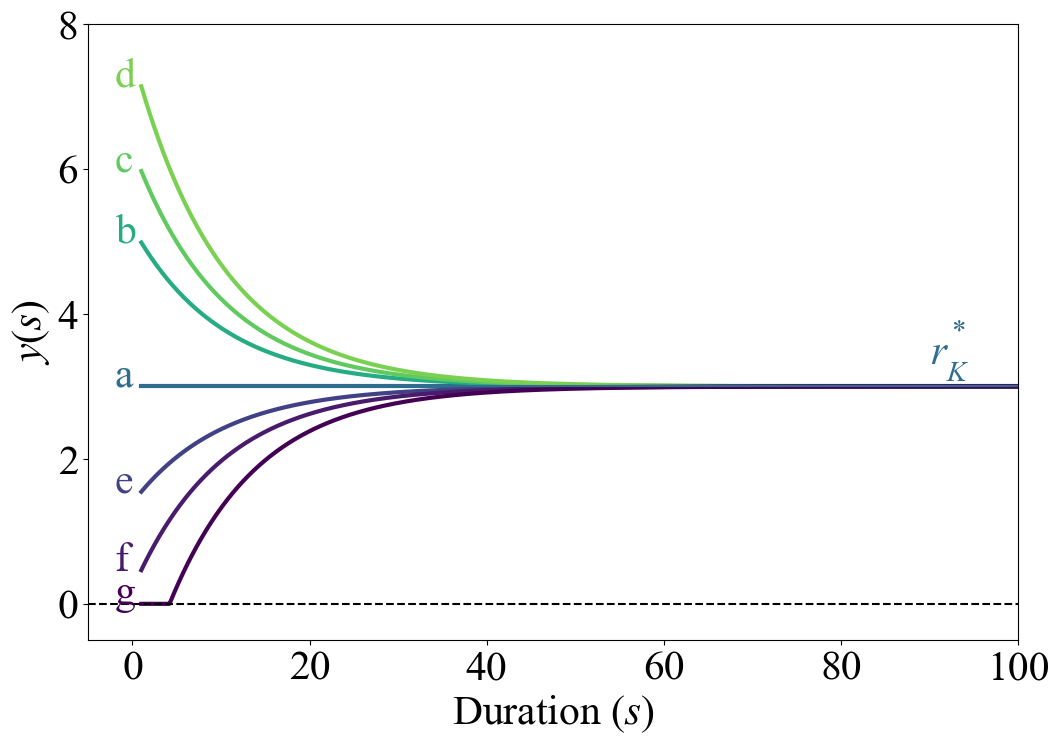

In [31]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_xlim((-5, 100))  
ax.set_ylim((-0.5, 8))  
labels = ['a','b','c','d','e','f', 'g']
marks = [0, 5, 8, 16, 35, 38, 48]

count = 0
used_colors = []

for t in range(0,time+1):
    alpha = 0.03*np.sin(0.1*t)
    beta = 0.25 + 0.25*np.cos(0.1*t)
    gamma = 0.35 + 0.15*np.cos(0.1*t)
    delta = 20
    
    alpha = 2.5*np.sin(0.1*t)
    x = np.linspace(1, 100, 1000)
    myfunc=metafunc(alpha, beta=beta, gamma=gamma, delta=delta)
        
    # Get spot curve (from P/R)
    R = 1
    P = recursive_price(1000, r_func=myfunc)
    s_t = 100*R/P
    pos = (s_t-y2.min())/(y2.max()-y2.min())
        
    # At specific points, draw the forward curve 
    # Parametrize forward curve
    
    if t in marks:
        forward_curve = np.array([myfunc(item) for item in x])-g
        forward_curve[forward_curve<0]=0
        color = cmap(pos)
        used_colors.append(color)
        ax.plot(x, 100*forward_curve, color=color, linewidth=3)
        ax.text(-2, 100*forward_curve[0], labels[count], color=color)
        
        count += 1
        
# Mark the first line again so this color is the one that shows in the long end
ax.plot(x, np.full(len(x), 3), color=used_colors[0])

ax.axhline(y=0, color='black', linestyle='dashed')
        
ax.set_xlabel(r'Duration ($s$)')
ax.set_ylabel(r"$y(s)$")
ax.text(90, 3.3, r"$r_K^*$", color=used_colors[0])

# plt.savefig(os.path.join(output, 'yield_curve_simulation_pt1.png'))

Text(0.5, 0, 'Shape of Yield Curve')

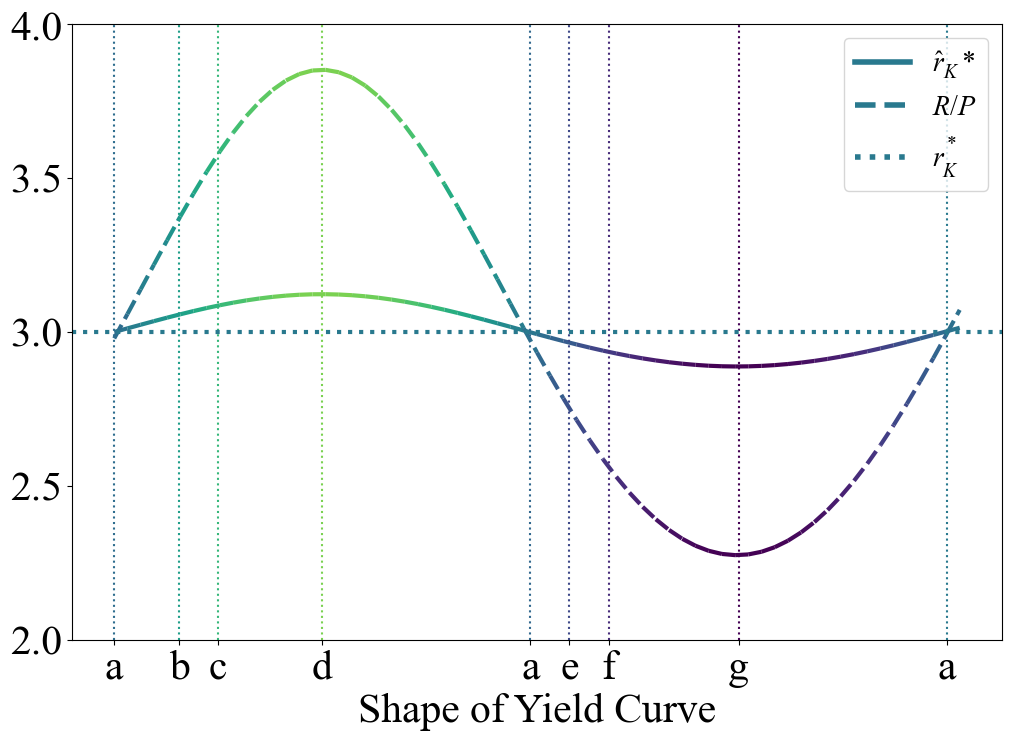

In [28]:
# Make gradient plot
x = np.linspace(0,10,time)
fig, ax = plt.subplots(figsize=(12,8))
colors = y1/y1.max()
points = np.array([x, y1]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap=cmap, linewidth=3)
lc.set_array(colors)
ax.add_collection(lc)

colors = y2/y2.max()
points = np.array([x, y2]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
lc = LineCollection(segments, cmap=cmap, linestyle='dashed', linewidth=3)
lc.set_array(colors)
ax.add_collection(lc)

ax.set_ylim(2, y2.max()+0.15)
ax.set_xlim(x.min()-0.5, x.max()+0.5)

count = 0
shift = [-0.12]*4 + [-0.2]*2 + [-0.1] + [-0.2]*2
for t in marks + [32,64]:
    ypos = y2[t]
    pos = (ypos-y2.min())/(y2.max()-y2.min())
    xpos = t/time * 10
    color = cmap(pos)
    ax.axvline(x=xpos, color=color, linestyle='dotted')
    count += 1
    
ax.axhline(y=3, color=color, linestyle='dotted', linewidth=3)
        
# Legend
custom_lines = [Line2D([0], [0], color=cmap(0.5), lw=4),
                Line2D([0], [0], color=cmap(0.5), lw=4, linestyle='dashed'),
                Line2D([0], [0], color=cmap(0.5), lw=4, linestyle='dotted')]
        
ax.legend(custom_lines, [r'$\hat{r}_K*$',r'$R/P$', r'$r_K^*$'], loc='upper right',prop={'family': 'Times New Roman', 'size':20})

# Axis ticks
ticks = np.array(marks+[32,64])/time * 10
ax.set_xticks(ticks, labels=labels + ['a','a'])

# Axis labels
ax.set_xlabel('Shape of Yield Curve')
# ax.set_ylabel("Estimated y* (%)")

# plt.savefig(os.path.join(output, 'yield_curve_simulation_pt2.png'))
